In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
from torch.utils.data import DataLoader, Dataset
import cv2, glob, numpy as np, pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:

# Set device (GPU if available)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
!kaggle datasets download -d tongpython/cat-and-dog
!unzip cat-and-dog.zip

Dataset URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog
License(s): CC0-1.0
cat-and-dog.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  cat-and-dog.zip
replace test_set/test_set/cats/_DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:

# Dataset paths
train_data_dir = 'training_set/training_set'
test_data_dir = 'test_set/test_set'

In [ ]:
# Custom Dataset Class
class CatsDogs(Dataset):
    def __init__(self, folder):
        cats = glob(folder + 'inflating: training_set/training_set/cats/cat.561.jpg')
        dogs = glob(folder + 'inflating: training_set/training_set/dogs/dog.723.jpg')
        self.fpaths = cats[:500] + dogs[:500]  # Use 500 samples each
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        # Shuffle data
        from random import shuffle, seed
        seed(10)
        shuffle(self.fpaths)

        self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths]

    def __len__(self):
        return len(self.fpaths)

    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = cv2.imread(f)[:, :, ::-1]  # Convert BGR to RGB
        im = cv2.resize(im, (224, 224))
        im = torch.tensor(im / 255).permute(2, 0, 1)  # Normalize to [0,1]
        im = self.normalize(im)
        return im.float().to(device), torch.tensor([target]).float().to(device)

In [ ]:
import glob

class CatsDogs(Dataset):
    def __init__(self, folder):
        cats = glob.glob(folder + '/cats/*.jpg')  # Get all cat images
        dogs = glob.glob(folder + '/dogs/*.jpg')  # Get all dog images
        self.fpaths = cats[:500] + dogs[:500]  # Use first 500 from each class

        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        from random import shuffle, seed
        seed(10)
        shuffle(self.fpaths)

        self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths]

    def __len__(self):
        return len(self.fpaths)

    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = cv2.imread(f)[:, :, ::-1]  # Convert BGR to RGB
        im = cv2.resize(im, (224, 224))
        im = torch.tensor(im / 255).permute(2, 0, 1)  # Normalize to [0,1]
        im = self.normalize(im)
        return im.float().to(device), torch.tensor([target]).float().to(device)


tensor([0.], device='cuda:0')


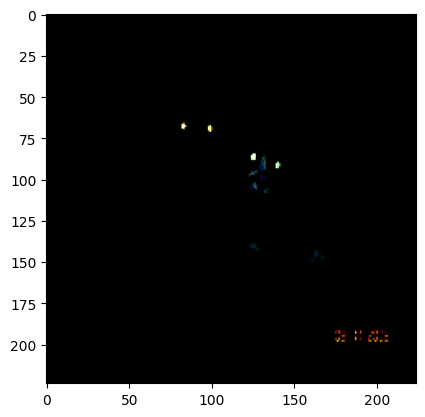

In [ ]:

# Load a sample image
data = CatsDogs(train_data_dir)
im, label = data[200]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchsummary import summary

# Define VGG16 Model (Without Pretrained Weights)
def get_model():
    model = models.vgg16(pretrained=False)  # No pre-trained weights (training from scratch)

    # Modify classifier for binary classification
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 1),
        nn.Sigmoid()
    )

    loss_fn = nn.BCELoss()  # Binary Cross Entropy Loss for classification
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    return model.to(device), loss_fn, optimizer

# Create model instance
model, criterion, optimizer = get_model()

# Print model summary
summary(model, (3, 224, 224))  # Input shape for RGB images


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
# Define VGG16 Model (without pre-trained weights)
def get_model():
    model = models.vgg16(pretrained=False) # Start from scratch

    # Freeze all model parameters
    for param in model.parameters():
        param.requires_grad = True # Allow training of all layers

    # Modify classifier for binary classification
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 1),
        nn.Sigmoid()
    )

    loss_fn = nn.BCELoss()  # Binary Cross Entropy Loss for classification
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    return model.to(device), loss_fn, optimizer  # ✅ This is inside the function

In [ ]:
# Training function
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()


In [ ]:
# Accuracy function
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()


In [ ]:
# Prepare DataLoaders
def get_data():
    train = CatsDogs(train_data_dir)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last=True)
    val = CatsDogs(test_data_dir)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last=True)
    return trn_dl, val_dl


In [ ]:
# Train the model
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

train_losses, train_accuracies = [], []
val_accuracies = []

for epoch in range(5):
    print(f"Epoch {epoch + 1}/5")

    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []

Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5


In [ ]:
 # Training
for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    train_epoch_losses.append(batch_loss)

    train_epoch_loss = np.array(train_epoch_losses).mean()

In [ ]:

    # Training Accuracy
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)


In [ ]:
# Validation Accuracy
for ix, batch in enumerate(iter(val_dl)):
    x, y = batch
    val_is_correct = accuracy(x, y, model)
    val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

In [ ]:
train_losses, train_accuracies, val_accuracies = [], [], []

for epoch in range(5):
    print(f"Epoch {epoch + 1}/5")

    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []

    # Training loop
    for x, y in iter(trn_dl):
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)

    train_epoch_loss = np.mean(train_epoch_losses)  # Store avg loss
    train_losses.append(train_epoch_loss)

    # Compute training accuracy for the whole epoch
    train_epoch_accuracy = np.mean([accuracy(x, y, model) for x, y in iter(trn_dl)])
    train_accuracies.append(train_epoch_accuracy)

    # Compute validation accuracy
    val_epoch_accuracy = np.mean([accuracy(x, y, model) for x, y in iter(val_dl)])
    val_accuracies.append(val_epoch_accuracy)

# Now, the lengths should match (both lists have 5 values)


Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5


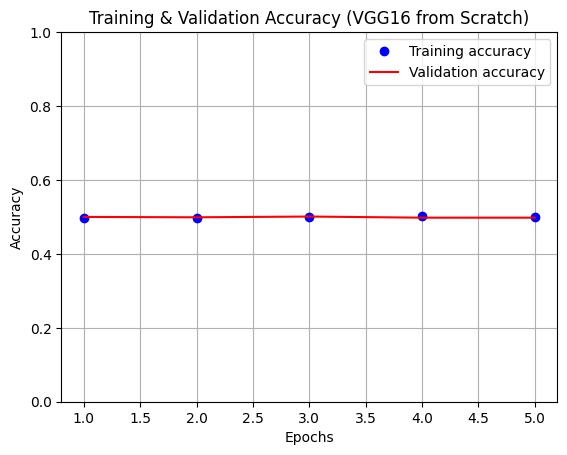

In [ ]:
# Plot Training and Validation Accuracy
epochs = np.arange(5) + 1
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training & Validation Accuracy (VGG16 from Scratch)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.show()

In [ ]:

# Model Evaluation
@torch.no_grad()
def evaluate_model(dataloader, model):
    model.eval()
    all_preds = []
    all_labels = []

    for x, y in dataloader:
        predictions = model(x).cpu().numpy()  # Move to CPU for processing
        y = y.cpu().numpy()  # Move labels to CPU
        predictions = (predictions > 0.5).astype(int)  # Convert to class labels
        all_preds.extend(predictions)
        all_labels.extend(y)

    return np.array(all_preds), np.array(all_labels)

In [ ]:
# Compute Metrics
y_pred, y_true = evaluate_model(val_dl, model)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.5000
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Confusion Matrix:
[[496   0]
 [496   0]]


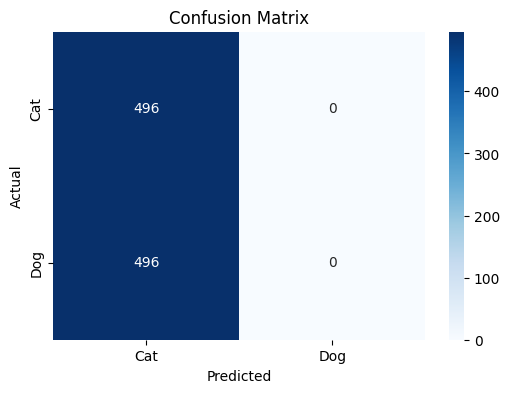

In [ ]:


# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
